In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import stim
import sinter
import pymatching

# Syurface code with MWPM: 

In [2]:
def get_logical_error_rate(distance, noise_rate, num_shots):
    circuit = stim.Circuit.generated(
        "surface_code:rotated_memory_z",
        rounds=distance,
        distance=distance,
        after_clifford_depolarization=noise_rate,
        after_reset_flip_probability=noise_rate,
        before_measure_flip_probability=noise_rate,
        before_round_data_depolarization=noise_rate
    )
    
    sampler = circuit.compile_detector_sampler()
    syndrome, actual_observables = sampler.sample(num_shots, separate_observables=True)
    
    model = circuit.detector_error_model(decompose_errors=True)
    matching = pymatching.Matching.from_detector_error_model(model)
    
    predicted_observables = matching.decode_batch(syndrome)
    
    logical_errors = np.sum(np.any(predicted_observables != actual_observables, axis=1))
    
    logical_error_rate = logical_errors / num_shots
    return logical_error_rate

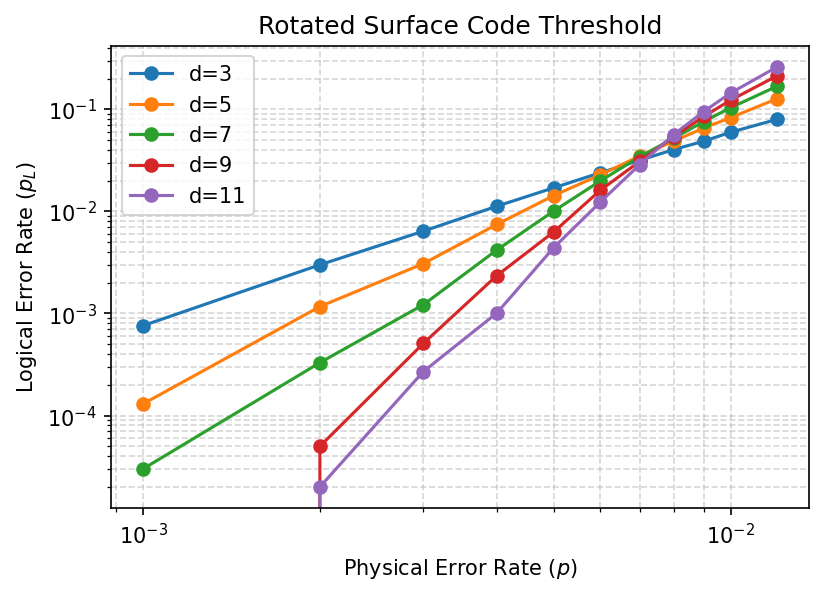

In [5]:
distances = [3, 5, 7, 9, 11]
noise_rates = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.010, 0.012]
num_shots = 100000 

plt.figure(figsize=(6, 4), dpi = 150)

for d in distances:
    error_rates = []
    for p in noise_rates:
        p_L = get_logical_error_rate(d, p, num_shots)
        error_rates.append(p_L)
    
    plt.plot(noise_rates, error_rates, marker='o', label=f'd={d}')

plt.yscale('log')
plt.xscale('log')
plt.title("Rotated Surface Code Threshold")
plt.xlabel("Physical Error Rate ($p$)")
plt.ylabel("Logical Error Rate ($p_L$)")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.show()

# Graph Neural network decoder: 

In [34]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch_geometric.data import HeteroData
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool, GraphConv, global_mean_pool
from tqdm import tqdm

In [35]:
def extract_bipartite_graph(dem: stim.DetectorErrorModel):
    H_rows, H_cols = [], []
    L_rows, L_cols = [], []
    error_probabilities = []
    
    error_idx = 0
    for instruction in dem:
        if instruction.type == "error":
            p = instruction.args_copy()[0]
            error_probabilities.append(p)
            
            targets = instruction.targets_copy()
            for target in targets:
                if target.is_relative_detector_id():
                    H_rows.append(target.val)
                    H_cols.append(error_idx)
                elif target.is_logical_observable_id():
                    L_rows.append(target.val)
                    L_cols.append(error_idx)
            error_idx += 1
            
    edge_index_e2d = torch.tensor([H_cols, H_rows], dtype=torch.long)
    edge_index_d2e = torch.tensor([H_rows, H_cols], dtype=torch.long)
    
    error_probabilities = np.array(error_probabilities)
    llr = np.log((1 - error_probabilities) / (error_probabilities + 1e-15))
    x_e_priors = torch.tensor(llr, dtype=torch.float32).unsqueeze(1)
    
    return edge_index_e2d, edge_index_d2e, x_e_priors, error_idx, dem.num_detectors

class SurfaceCodeDataset(Dataset):
    def __init__(self, distance: int, noise_rate: float, num_shots: int):
        self.circuit = stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds=distance,
            distance=distance,
            after_clifford_depolarization=noise_rate,
            after_reset_flip_probability=noise_rate,
            before_measure_flip_probability=noise_rate,
            before_round_data_depolarization=noise_rate
        )
        
        self.dem = self.circuit.detector_error_model(decompose_errors=True)
        
        e2d, d2e, priors, num_e, num_d = extract_bipartite_graph(self.dem)
        self.edge_index_e2d = e2d
        self.edge_index_d2e = d2e
        self.x_e_priors = priors
        self.num_errors = num_e
        self.num_detectors = num_d
        
        sampler = self.circuit.compile_detector_sampler()
        self.syndromes, self.observables = sampler.sample(
            num_shots, separate_observables=True
        )
        
        self.syndromes = torch.tensor(self.syndromes, dtype=torch.float32)
        self.observables = torch.tensor(self.observables, dtype=torch.float32)

    def __len__(self):
        return len(self.syndromes)

    def __getitem__(self, idx):
        data = HeteroData()
        
        data['detector'].x = self.syndromes[idx].unsqueeze(1)
        data['error'].x = self.x_e_priors
        
        data['error', 'triggers', 'detector'].edge_index = self.edge_index_e2d
        data['detector', 'triggered_by', 'error'].edge_index = self.edge_index_d2e
        
        data.y = self.observables[idx]
        
        return data

def get_dataloader(distance: int, noise_rate: float, num_shots: int, batch_size: int):
    dataset = SurfaceCodeDataset(distance, noise_rate, num_shots)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [36]:
class BipartiteMessagePassing(MessagePassing):
    def __init__(self, node_dim, msg_dim):
        super().__init__(aggr='add')
        
        self.msg_mlp = nn.Sequential(
            nn.Linear(node_dim, msg_dim),
            nn.ReLU(),
            nn.Linear(msg_dim, msg_dim)
        )
        
        self.update_mlp = nn.Sequential(
            nn.Linear(node_dim + msg_dim, node_dim),
            nn.ReLU(),
            nn.Linear(node_dim, node_dim)
        )

    def forward(self, x_source, x_target, edge_index):
        return self.propagate(edge_index, x=(x_source, x_target))

    def message(self, x_j):
        return self.msg_mlp(x_j)

    def update(self, aggr_out, x_target):
        concat_features = torch.cat([x_target, aggr_out], dim=-1)
        return self.update_mlp(concat_features)


class NeuralBPDecoder(nn.Module):
    def __init__(self, hidden_dim=64, num_layers=5, num_observables=1):
        super().__init__()
        self.num_layers = num_layers
        
        self.embed_d = nn.Linear(1, hidden_dim)
        self.embed_e = nn.Linear(1, hidden_dim)
        
        self.d2e_layers = nn.ModuleList(
            [BipartiteMessagePassing(hidden_dim, hidden_dim) for _ in range(num_layers)]
        )
        self.e2d_layers = nn.ModuleList(
            [BipartiteMessagePassing(hidden_dim, hidden_dim) for _ in range(num_layers)]
        )
        
        self.readout = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, num_observables)
        )

    def forward(self, data):
        x_d = self.embed_d(data['detector'].x)
        x_e = self.embed_e(data['error'].x)
        
        edge_index_d2e = data['detector', 'triggered_by', 'error'].edge_index
        edge_index_e2d = data['error', 'triggers', 'detector'].edge_index
        
        for i in range(self.num_layers):
            x_e = self.d2e_layers[i](x_d, x_e, edge_index_d2e)
            x_d = self.e2d_layers[i](x_e, x_d, edge_index_e2d)
            
        batch_e = data['error'].batch
        if batch_e is None:
            batch_e = torch.zeros(x_e.size(0), dtype=torch.long, device=x_e.device)
            
        pooled_e = global_mean_pool(x_e, batch_e)
        logits = self.readout(pooled_e)
        
        return logits

In [37]:
def train_decoder(model, train_data, val_data, batch_size, epochs, device):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            logits = model(batch.x, batch.edge_index, getattr(batch, 'edge_attr', None), batch.batch)
            loss = criterion(logits.squeeze(), batch.y.float())
            
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * batch.num_graphs

        avg_train_loss = total_train_loss / len(train_data)

        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                logits = model(batch.x, batch.edge_index, getattr(batch, 'edge_attr', None), batch.batch)
                loss = criterion(logits.squeeze(), batch.y.float())
                total_val_loss += loss.item() * batch.num_graphs

        avg_val_loss = total_val_loss / len(val_data)
        scheduler.step(avg_val_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    return model

In [38]:
def evaluate_logical_error_rate(model, test_data, batch_size, device):
    loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    model = model.to(device)
    model.eval()
    
    incorrect_predictions = 0
    total_samples = len(test_data)
    
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            logits = model(batch.x, batch.edge_index, getattr(batch, 'edge_attr', None), batch.batch)
            
            predictions = (torch.sigmoid(logits.squeeze()) > 0.5).int()
            incorrect_predictions += (predictions != batch.y).sum().item()
            
    return incorrect_predictions / total_samples

In [39]:
def plot_threshold_comparison(distances, physical_error_rates, trained_models, num_samples, batch_size, device):
    gnn_logical_errors = {d: [] for d in distances}
    mwpm_logical_errors = {d: [] for d in distances}

    for d in distances:
        for p in physical_error_rates:
            gnn_dataset, syndromes, true_obs, matching = generate_eval_data(d, p, num_samples)
            
            p_L_gnn = evaluate_logical_error_rate(trained_models[d], gnn_dataset, batch_size, device)
            gnn_logical_errors[d].append(p_L_gnn)
            
            mwpm_incorrect = 0
            for i in range(num_samples):
                prediction = matching.decode(syndromes[i])
                if tuple(prediction) != tuple(true_obs[i]):
                    mwpm_incorrect += 1
            mwpm_logical_errors[d].append(mwpm_incorrect / num_samples)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    colors = plt.cm.viridis(np.linspace(0, 0.9, len(distances)))
    
    for idx, d in enumerate(distances):
        ax1.plot(physical_error_rates, gnn_logical_errors[d], marker='o', color=colors[idx], label=f'd={d}')
        ax2.plot(physical_error_rates, mwpm_logical_errors[d], marker='x', linestyle='--', color=colors[idx], label=f'd={d}')
        
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('Physical Error Rate $p$')
    ax1.set_ylabel('Logical Error Rate $p_L$')
    ax1.set_title('GNN Decoder')
    ax1.legend()
    ax1.grid(True, which="both", ls="--", alpha=0.5)

    ax2.set_xscale('log')
    ax2.set_xlabel('Physical Error Rate $p$')
    ax2.set_title('MWPM Decoder')
    ax2.legend()
    ax2.grid(True, which="both", ls="--", alpha=0.5)

    plt.tight_layout()
    plt.show()

In [40]:
def generate_data(d, p, num_shots):
    circuit = stim.Circuit.generated(
        "surface_code:rotated_memory_z", 
        distance=d, 
        rounds=d, 
        after_clifford_depolarization=p
    )
    dem = circuit.detector_error_model(decompose_errors=True)
    matching = pymatching.Matching.from_detector_error_model(dem)
    
    nx_graph = matching.to_networkx()
    max_node = max(nx_graph.nodes(), default=dem.num_detectors - 1)
    num_nodes_total = max_node + 1
    
    edge_index = []
    edge_attr = []
    for u, v, data in nx_graph.edges(data=True):
        edge_index.append([u, v])
        edge_index.append([v, u])
        w = data.get('weight', 0.0)
        edge_attr.extend([[w], [w]])
        
    if edge_index:
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0, 1), dtype=torch.float)
    
    sampler = circuit.compile_detector_sampler()
    syndromes, observables = sampler.sample(num_shots, separate_observables=True)
    
    dataset = []
    for i in range(num_shots):
        x = np.zeros((num_nodes_total, 1), dtype=np.float32)
        x[:dem.num_detectors, 0] = syndromes[i]
        
        dataset.append(Data(
            x=torch.tensor(x), 
            edge_index=edge_index, 
            edge_attr=edge_attr, 
            y=torch.tensor([observables[i, 0]], dtype=torch.float)
        ))
        
    return dataset, syndromes, observables, matching

In [41]:
class QEC_GNN(nn.Module):
    def __init__(self, hidden_dim=32):
        super().__init__()
        self.conv1 = GraphConv(1, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.conv3 = GraphConv(hidden_dim, hidden_dim)
        self.lin = nn.Linear(hidden_dim, 1)

    def forward(self, x, edge_index, batch):
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        x = torch.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x).squeeze(-1)

def train_gnn(dataset, epochs=15, batch_size=128, lr=0.005, device='cpu'):
    model = QEC_GNN().to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model.train()
    for epoch in range(epochs):
        for batch in loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()
    return model

def evaluate_gnn(model, dataset, batch_size=128, device='cpu'):
    model.eval()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    incorrect = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            pred = (torch.sigmoid(out) > 0.5).float()
            incorrect += (pred != batch.y).sum().item()
    return incorrect / len(dataset)

In [ ]:
distances = [3, 5, 7, 9]
physical_probs = [0.001, 0.005, 0.01, 0.015, 0.02]
shots_train = 5000
shots_test = 2000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

gnn_logical_errors = {d: [] for d in distances}
mwpm_logical_errors = {d: [] for d in distances}

for d in distances:
    for p in tqdm(physical_probs):
        train_dataset, _, _, _ = generate_data(d, p, shots_train)
        test_dataset, test_syn, test_obs, matching = generate_data(d, p, shots_test)
        
        model = train_gnn(train_dataset, epochs=15, device=device)
        
        p_L_gnn = evaluate_gnn(model, test_dataset, device=device)
        gnn_logical_errors[d].append(p_L_gnn)
        
        predicted_observables = matching.decode_batch(test_syn)
        mwpm_incorrect = np.sum(np.any(predicted_observables != test_obs, axis=1))
        mwpm_logical_errors[d].append(mwpm_incorrect / shots_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
colors = plt.cm.viridis(np.linspace(0, 0.9, len(distances)))

for idx, d in enumerate(distances):
    ax1.plot(physical_probs, gnn_logical_errors[d], marker='o', color=colors[idx], label=f'd={d}')
    ax2.plot(physical_probs, mwpm_logical_errors[d], marker='x', linestyle='--', color=colors[idx], label=f'd={d}')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Physical Error Rate $p$')
ax1.set_ylabel('Logical Error Rate $p_L$')
ax1.set_title('GNN Decoder')
ax1.legend()
ax1.grid(True, which="both", ls="--", alpha=0.5)

ax2.set_xscale('log')
ax2.set_xlabel('Physical Error Rate $p$')
ax2.set_title('MWPM Decoder (PyMatching)')
ax2.legend()
ax2.grid(True, which="both", ls="--", alpha=0.5)

plt.tight_layout()
plt.show()

KeyboardInterrupt: 